<a href="https://colab.research.google.com/github/luckyos-code/DP-X-COVID/blob/main/baseline_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detection of COVID-19 in X-Ray Images (COVID-19 vs. Normal)

##### Notebook settings

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Prerequisites

###### Init Kaggle-API
**Important:** Before running the cells below follow [this](https://stackoverflow.com/questions/49310470/using-kaggle-datasets-in-google-colab) stackoverflow questions accepted answer to get the kaggle.json file. Once you have the json file on your local machine,run the code below and upload the json file when prompted in the output cell. ([credit](https://github.com/mobassir94/Practicing-Tensorflow/blob/master/kaggle_Pneumonia_Detection.ipynb))

In [ ]:
!pip uninstall -q -y kaggle
!pip install -q --upgrade pip
!pip install -q kaggle==1.5.6
!mkdir  /root/.kaggle
from google.colab import files as colab
colab.upload()
!cp kaggle.json /root/.kaggle && chmod 600 /root/.kaggle/kaggle.json
!rm kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


Saving kaggle.json to kaggle.json


##### Download dataset

###### *COVID-19 Radiography Database*  
[Kaggle](https://www.kaggle.com/tawsifurrahman/covid19-radiography-database)

M.E.H. Chowdhury, T. Rahman, A. Khandakar, R. Mazhar, M.A. Kadir, Z.B. Mahbub, K.R. Islam, M.S. Khan, A. Iqbal, N. Al-Emadi, M.B.I. Reaz, M. T. Islam,
“Can AI help in screening Viral and COVID-19 pneumonia?”
(2020) [Paper](https://ieeexplore.ieee.org/document/9144185)

Rahman, T., Khandakar, A., Qiblawey, Y., Tahir, A., Kiranyaz, S., Kashem, S.B.A., Islam, M.T., Maadeed, S.A., Zughaier, S.M., Khan, M.S. and Chowdhury, M.E. “Exploring the Effect of Image Enhancement Techniques on COVID-19 Detection using Chest X-ray Images.” (2020) [Paper](https://doi.org/10.1016/j.compbiomed.2021.104319)

In [ ]:
!kaggle datasets download -d tawsifurrahman/covid19-radiography-database
!unzip -q covid19-radiography-database.zip
!rm covid19-radiography-database.zip

 99% 737M/745M [00:25<00:00, 22.0MB/s]
100% 745M/745M [00:25<00:00, 30.8MB/s]


##### Import libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle, class_weight

import keras
from keras.layers import Input, Conv2D, Activation, BatchNormalization, MaxPool2D, GlobalAveragePooling2D, Dense, Dropout, LeakyReLU, Flatten, ZeroPadding2D
from keras import layers
from tensorflow.keras.applications import ResNet50V2, EfficientNetB4
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.layers.merge import add
from keras.activations import relu, softmax
from keras.models import Sequential
from keras import regularizers
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.optimizers import Adam

import os, shutil, random, cv2
from shutil import copyfile
from distutils.dir_util import copy_tree
from tqdm import tqdm

##### Define constants

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Set fixed random seed
seed = 42
np.random.seed(seed)
random.seed(seed)
random_state = 42

# Data parameters
SPLIT = 0.15
IMBALANCE_RATIO = 1.5

# Model parameters
BATCH_SIZE = 8
IMG_SIZE = [256, 256] # same as dataset image size
EPOCHS = 20

## Data


### Create dataset

In [ ]:
savepath = 'data'

## dataset from https://www.kaggle.com/tawsifurrahman/covid19-radiography-database

# path to normal 
normal_imgpath = 'COVID-19_Radiography_Dataset/Normal'
normal_csvpath = 'COVID-19_Radiography_Dataset/Normal.metadata.xlsx'

# path to covid-19 
covid_imgpath = 'COVID-19_Radiography_Dataset/COVID'
covid_csvpath = 'COVID-19_Radiography_Dataset/COVID.metadata.xlsx'

# path to opacity 
opacity_imgpath = 'COVID-19_Radiography_Dataset/Lung_Opacity'
opacity_csvpath = 'COVID-19_Radiography_Dataset/Lung_Opacity.metadata.xlsx'

# path to pneumonia 
pneumonia_imgpath = 'COVID-19_Radiography_Dataset/Viral Pneumonia'
pneumonia_csvpath = 'COVID-19_Radiography_Dataset/Viral Pneumonia.metadata.xlsx'

In [ ]:
# stats
normal_cnt = len([name for name in os.listdir(normal_imgpath) if os.path.isfile(os.path.join(normal_imgpath, name))])
covid_cnt = len([name for name in os.listdir(covid_imgpath) if os.path.isfile(os.path.join(covid_imgpath, name))])
pneumonia_cnt = len([name for name in os.listdir(opacity_imgpath) if os.path.isfile(os.path.join(opacity_imgpath, name))]) + len([name for name in os.listdir(pneumonia_imgpath) if os.path.isfile(os.path.join(pneumonia_imgpath, name))])

class_count = {'normal': normal_cnt, 'COVID-19': covid_cnt, 'pneumonia': pneumonia_cnt}
print('Class count: ', class_count)
print('Total images: ', normal_cnt + covid_cnt + pneumonia_cnt)

Class count:  {'normal': 10192, 'COVID-19': 3616, 'pneumonia': 7357}
Total images:  21165


### Load dataset

###### Retrieve filenames (paths) and labels

In [ ]:
def get_data(paths, label_encoding):
    normal_imgpath, covid_imgpath = paths
    filenames = []
    y_labels = []

    # COVID-19
    covid_images = [covid_imgpath + '/' + name for name in os.listdir(covid_imgpath) if os.path.isfile(os.path.join(covid_imgpath, name))]
    filenames.extend(covid_images)
    y_labels.extend([label_encoding.index('COVID-19') for img in covid_images])

    # normal
    normal_images = random.sample(
        [normal_imgpath + '/' + name for name in os.listdir(normal_imgpath) if os.path.isfile(os.path.join(normal_imgpath, name))],
        int(IMBALANCE_RATIO*len(covid_images))) # TODO exception if sample size is greater than list
    filenames.extend(normal_images)
    y_labels.extend([label_encoding.index('normal') for img in normal_images])

    return np.array(filenames), np.array(y_labels)

In [ ]:
datapaths = ['COVID-19_Radiography_Dataset/Normal', 'COVID-19_Radiography_Dataset/COVID']
label_encoding = ['normal', 'COVID-19'] # normal = 0, COVID-19 = 1

files, labels = get_data(datapaths, label_encoding)

###### Create train-test split

In [ ]:
# create train-val-test split
x_train, x_val, y_train, y_val = train_test_split(files, labels, test_size=2*SPLIT, random_state=random_state)
x_val, x_test, y_val, y_test = train_test_split(x_val, y_val, test_size=0.5, random_state=random_state)

In [ ]:
def get_distribution(y):
    return {'normal': np.count_nonzero(y == 0),
            'COVID-19': np.count_nonzero(y == 1)}

In [ ]:
TRAIN_DISTRIBUTION = get_distribution(y_train)
VAL_DISTRIBUTION = get_distribution(y_val)
TEST_DISTRIBUTION = get_distribution(y_test)
print('train set: ', TRAIN_DISTRIBUTION)
print('val set:   ', VAL_DISTRIBUTION)
print('test set:  ', TEST_DISTRIBUTION)

train set:  {'normal': 3810, 'COVID-19': 2518}
val set:    {'normal': 804, 'COVID-19': 552}
test set:   {'normal': 810, 'COVID-19': 546}


###### Create tensors

In [ ]:
# no one hot encoding for binary class classification
#y_train_one_hot = to_categorical(y_train, 2)
#y_val_one_hot = to_categorical(y_val, 2)
#y_test_one_hot = to_categorical(y_test, 2)
# build tensorflow dataset
train_files = tf.data.Dataset.from_tensor_slices((x_train, y_train))
val_files = tf.data.Dataset.from_tensor_slices((x_val, y_val))
test_files = tf.data.Dataset.from_tensor_slices((x_test, y_test))

###### Image retrieval

In [ ]:
def get_img(x, y):
    file_path = x
    label = y
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_image(img, channels=3, expand_animations = False)
    # make sure img has desired number of channels
    # rgb = 3, grayscale = 1
    #img = tf.cond(tf.shape(img)[2] == 1, lambda: tf.image.grayscale_to_rgb(img), lambda: img)
    return img, label

In [ ]:
train_ds = train_files.map(get_img, num_parallel_calls=AUTOTUNE)
val_ds = val_files.map(get_img, num_parallel_calls=AUTOTUNE)
test_ds = test_files.map(get_img, num_parallel_calls=AUTOTUNE)

In [ ]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_ds).numpy()
VAL_IMG_COUNT = tf.data.experimental.cardinality(val_ds).numpy()
TEST_IMG_COUNT = tf.data.experimental.cardinality(test_ds).numpy()
print(
    'Train: ' + str(TRAIN_IMG_COUNT) + ',',
    'Val: ' + str(VAL_IMG_COUNT) + ',',
    'Test: ' + str(TEST_IMG_COUNT),
)

Train: 6328, Val: 1356, Test: 1356


### Prepare for training

###### Define preprocessing

In [ ]:
# ideas
#   1. crop top, sometimes there is text in the top part of the image
#   2. central crop, crop the central region of the image with an area
#      containing 87.5% of the original image
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMG_SIZE[0], IMG_SIZE[1]),
  layers.experimental.preprocessing.Rescaling(1./255)
])

###### Define data augmentation

In [ ]:
# implemented as keras layers below but kept for quick overview
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range=(0.85, 1.15), # randomly zoom image 
        brightness_range=(0.9, 1.1), # randomly shift brightness
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False,    # randomly flip images
        fill_mode='constant',   # constant filling of points outside boundaries of input
        cval=0.,)   # fill with zeros, see fill_mode

In [ ]:
class RandomBrightness(layers.Layer):
  def __init__(self, factor=0.1, **kwargs):
    super().__init__(**kwargs)
    self.factor = factor

  def call(self, x):
    return tf.image.random_brightness(x, max_delta=self.factor)

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal"),
  layers.experimental.preprocessing.RandomRotation(0.1, fill_mode='constant'),
  layers.experimental.preprocessing.RandomTranslation(0.1, 0.1, fill_mode='constant'),
  layers.experimental.preprocessing.RandomZoom(0.15, fill_mode='constant'),
  RandomBrightness(0.1),
])

###### Prepare batches

In [ ]:
def prepare_training(ds, shuffle=False, repeat=False, augment=False, cache=True, shuffle_buffer_size=1000):
    # Resize and rescale all datasets
    ds = ds.map(lambda x, y: (resize_and_rescale(x), y),
                num_parallel_calls=AUTOTUNE)

    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    if shuffle:
        ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    # repeat training set forever
    if repeat:
        ds = ds.repeat()
    else:
        ds = ds.repeat(1)

    # batch all datasets
    ds = ds.batch(BATCH_SIZE)

    # use data augmentation only on the training set
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                    num_parallel_calls=AUTOTUNE)

    # fetches batches in the background while training the model
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

In [ ]:
train_batched = prepare_training(train_ds, shuffle=True, repeat=True, augment=True)
val_batched = prepare_training(val_ds)
test_batched = prepare_training(test_ds)

### Visualization

###### Distribution of labels in the sets

In [ ]:
def plot_distributions(distributions):
    sns.set_style('darkgrid')
    n_plots = len(distributions)
    fig, ax = plt.subplots(1,n_plots, figsize=(15,5))
    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    for i, x in enumerate(distributions.items()):
        name = x[0]
        dis = x[1]
        keys = list(dis.keys())
        values = list(dis.values())
        sns.barplot(x=keys, y=values, ax=ax[i]).set_title(name)
    fig.show()

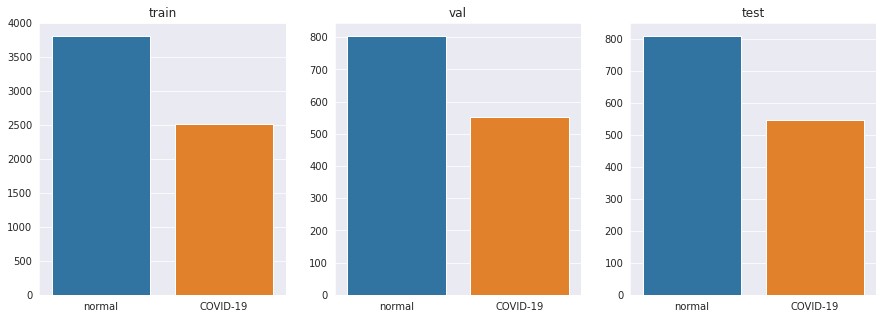

In [ ]:
plot_distributions({'train': TRAIN_DISTRIBUTION, 'val': VAL_DISTRIBUTION, 'test': TEST_DISTRIBUTION})

###### Images from a training batch

In [ ]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(np.log(BATCH_SIZE) / np.log(2), np.log(BATCH_SIZE) / np.log(2), n+1)
        plt.imshow(image_batch[n])
        if label_batch[n] == 0:
            plt.title("NORMAL")
        elif label_batch[n] == 1:
            plt.title("COVID-19")
        plt.axis("off")

In [ ]:
image_batch, label_batch = next(iter(train_batched))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


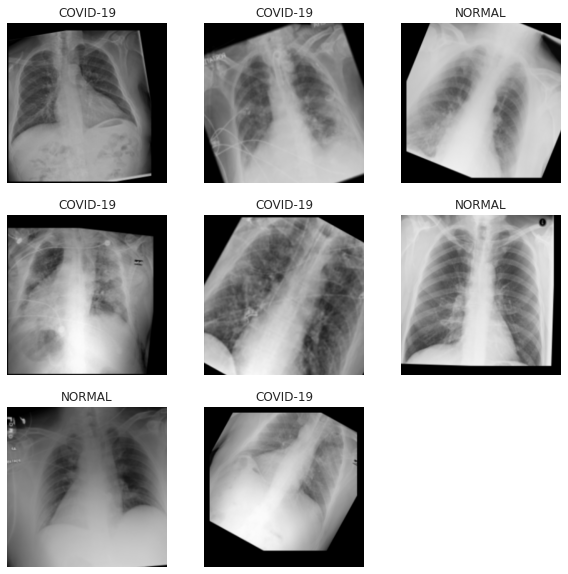

In [ ]:
show_batch(image_batch.numpy(), label_batch.numpy())

## Tuning

### Data Imbalance Correction

###### Define class weights

In [ ]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)

class_weight_dict = dict(enumerate(class_weights))

weight_iter = iter(class_weight_dict.values())
print('Weight for normal: \t{:.2f}'.format(next(weight_iter)))
print('Weight for COVID-19: \t{:.2f}'.format(next(weight_iter)))

Weight for normal: 	0.83
Weight for COVID-19: 	1.26


### Learning rate decay

In [ ]:
learning_rate_decay = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.1, min_lr=1e-6)

### Early stopping


In [ ]:
# checkpoint = ModelCheckpoint("x-covid.h5", monitor=monitor='val_loss', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

## ResNet50V2
V1  
Kaiming He, et al.
**Deep residual learning for image recognition.**
(2016)
[Google Scholar](https://scholar.google.com/scholar?cluster=9281510746729853742&hl=en&as_sdt=0,5)

V2  
Kaiming He, et al.
**Identity mappings in deep residual networks.** 
(2016)
[Google Scholar](https://scholar.google.com/scholar?cluster=14035416619237709781&hl=en&as_sdt=0,5)

### Model definition

Transfer learning: initalize with weights pretrained on ImageNet

In [ ]:
def resnet50_builder():
    # load pretrained ResNet50V2 (ImageNet) without output
    resnet = ResNet50V2(include_top = False,
                       weights = 'imagenet',
                       input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),)
    
    # make resnet layers trainable
    resnet.trainable = True
    # try freeze first pretrained layers, train later layers
    #for layer in resnet.layers[:103]:
    #    layer.trainable=False
    
    model = Sequential([
        Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
        # add pretrained resnet layer to model
        resnet,
        # add last pooling layer
        GlobalAveragePooling2D(name='AvgPool'),
        # add dropout (inspired by inception-resnet-v2)
        Dropout(0.2, name='Dropout'),
        # add classification layer for normal/COVID-19
        Dense(units=1, activation='sigmoid', name='Output'),
    ], name='ResNet50')
    
    return model

In [ ]:
# try out finding good split for trainable part
#resnet50.layers[0].layers[104]
#len([layer for layer in resnet50.layers[0].layers if isinstance(layer, keras.layers.Conv2D)])

In [ ]:
resnet50 = resnet50_builder()

METRICS = [
    'accuracy',
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall')
]

resnet50.compile(
    # very low learning rate to adapt pretrained weights to new data without
    # overfitting because of small dataset
    optimizer=Adam(lr=1e-5), # default: 1e-3
    loss='binary_crossentropy',
    metrics=METRICS
)

In [ ]:
resnet50.summary()

Model: "ResNet50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 8, 8, 2048)        23564800  
_________________________________________________________________
AvgPool (GlobalAveragePoolin (None, 2048)              0         
_________________________________________________________________
Dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
Output (Dense)               (None, 1)                 2049      
Total params: 23,566,849
Trainable params: 23,521,409
Non-trainable params: 45,440
_________________________________________________________________


### Training

In [ ]:
history_resnet = resnet50.fit(
    train_batched,
    steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_batched,
    validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
    class_weight=class_weight_dict,
    callbacks = [learning_rate_decay, early_stopping],
)

Epoch 1/20
791/791 [==============================] - 260s 318ms/step - loss: 0.5019 - accuracy: 0.7270 - precision: 0.6348 - recall: 0.8378 - val_loss: 0.2287 - val_accuracy: 0.9283 - val_precision: 0.8771 - val_recall: 0.9583
Epoch 2/20
791/791 [==============================] - 247s 312ms/step - loss: 0.2790 - accuracy: 0.8883 - precision: 0.8448 - recall: 0.8804 - val_loss: 0.1938 - val_accuracy: 0.9216 - val_precision: 0.8493 - val_recall: 0.9819
Epoch 3/20
791/791 [==============================] - 246s 311ms/step - loss: 0.2234 - accuracy: 0.9150 - precision: 0.8828 - recall: 0.9092 - val_loss: 0.2620 - val_accuracy: 0.8787 - val_precision: 0.7776 - val_recall: 0.9837
Epoch 4/20
791/791 [==============================] - 245s 310ms/step - loss: 0.1941 - accuracy: 0.9289 - precision: 0.8951 - recall: 0.9350 - val_loss: 0.0939 - val_accuracy: 0.9756 - val_precision: 0.9658 - val_recall: 0.9746
Epoch 5/20
791/791 [==============================] - 247s 312ms/step - loss: 0.1613 - a

### Evaluation

###### Visualize performance

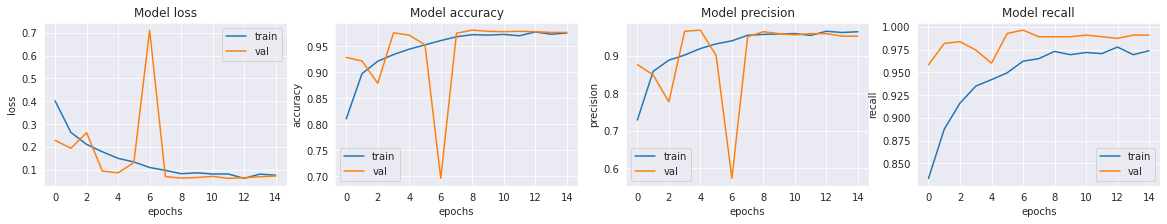

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['loss', 'accuracy', 'precision', 'recall']):
    ax[i].plot(history_resnet.history[met])
    ax[i].plot(history_resnet.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

###### Predict on test set

In [ ]:
loss, acc, prec, rec = resnet50.evaluate(test_batched)
print("Loss of the model is - " , loss)
print("Accuracy of the model is - " , acc*100 , "%")
print("Precision of the model is - " , prec)
print("Recall of the model is - " , rec)

170/170 [==============================] - 17s 99ms/step - loss: 0.0598 - accuracy: 0.9779 - precision: 0.9542 - recall: 0.9927
Loss of the model is -  0.05979263782501221
Accuracy of the model is -  97.78761267662048 %
Precision of the model is -  0.9542253613471985
Recall of the model is -  0.9926739931106567


## EfficientNet-B4
Mingxing Tan, Quoc V. Le.
**EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks.**
(2019)
[Google Scholar](https://scholar.google.com/scholar?hl=en&as_sdt=0%2C5&q=EfficientNet%3A+Rethinking+Model+Scaling+for+Convolutional+Neural+Networks&btnG=)

### Model definition

Transfer learning: initalize with weights pretrained on ImageNet

In [ ]:
DENSE_KERNEL_INITIALIZER = {
    'class_name': 'VarianceScaling',
    'config': {
        'scale': 1. / 3.,
        'mode': 'fan_out',
        'distribution': 'uniform'
    }
}

def effnetb4_builder():
    # load pretrained EfficientNetB4 (ImageNet) without output
    effnet = EfficientNetB4(include_top = False,
                       weights = 'imagenet',
                       input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),)
    
    # make resnet layers trainable
    effnet.trainable = True
    # TODO try freeze first pretrained layers, train later layers
    #for layer in reffnet.layers[:103]:
    #    layer.trainable=False
    
    model = Sequential([
        Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
        # add pretrained effnet layer to model
        effnet,
        # add last pooling layer
        GlobalAveragePooling2D(name='AvgPool'),
        # add dropout
        Dropout(0.2, name='Dropout'),
        # add classification layer for normal/COVID-19
        Dense(units=1, activation='sigmoid', kernel_initializer=DENSE_KERNEL_INITIALIZER, name='Output'),
    ], name='EfficientNetB4')
    
    return model

In [ ]:
# TODO try out finding good split for trainable part
#effnetb4.layers[0].layers[104]
#len([layer for layer in effnetb4.layers[0].layers if isinstance(layer, keras.layers.Conv2D)])

In [ ]:
effnetb4 = effnetb4_builder()

METRICS = [
    'accuracy',
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall')
]

effnetb4.compile(
    # very low learning rate to adapt pretrained weights to new data without
    # overfitting because of small dataset
    optimizer=Adam(lr=1e-5), # default: 1e-3
    loss='binary_crossentropy',
    metrics=METRICS
)

In [ ]:
effnetb4.summary()

Model: "EfficientNetB4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb4 (Functional)  (None, 8, 8, 1792)        17673823  
_________________________________________________________________
AvgPool (GlobalAveragePoolin (None, 1792)              0         
_________________________________________________________________
Dropout (Dropout)            (None, 1792)              0         
_________________________________________________________________
Output (Dense)               (None, 1)                 1793      
Total params: 17,675,616
Trainable params: 17,550,409
Non-trainable params: 125,207
_________________________________________________________________


### Training

In [ ]:
history_effnetb4 = effnetb4.fit(
    train_batched,
    steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_batched,
    validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
    class_weight=class_weight_dict,
    callbacks = [learning_rate_decay, early_stopping],
)

Epoch 1/20
791/791 [==============================] - 476s 573ms/step - loss: 1.2915 - accuracy: 0.6319 - precision: 0.5342 - recall: 0.6754 - val_loss: 2.2467 - val_accuracy: 0.5318 - val_precision: 0.4638 - val_recall: 0.9528
Epoch 2/20
791/791 [==============================] - 448s 566ms/step - loss: 0.7639 - accuracy: 0.7662 - precision: 0.6857 - recall: 0.7719 - val_loss: 0.7804 - val_accuracy: 0.7138 - val_precision: 0.6038 - val_recall: 0.8657
Epoch 3/20
791/791 [==============================] - 447s 565ms/step - loss: 0.6860 - accuracy: 0.7925 - precision: 0.7203 - recall: 0.7930 - val_loss: 0.8105 - val_accuracy: 0.6930 - val_precision: 0.5785 - val_recall: 0.9093
Epoch 4/20
791/791 [==============================] - 448s 567ms/step - loss: 0.5544 - accuracy: 0.8280 - precision: 0.7635 - recall: 0.8340 - val_loss: 0.6808 - val_accuracy: 0.6945 - val_precision: 0.5806 - val_recall: 0.9020
Epoch 5/20
791/791 [==============================] - 448s 566ms/step - loss: 0.4918 - a

### Evaluation

###### Visualize performance

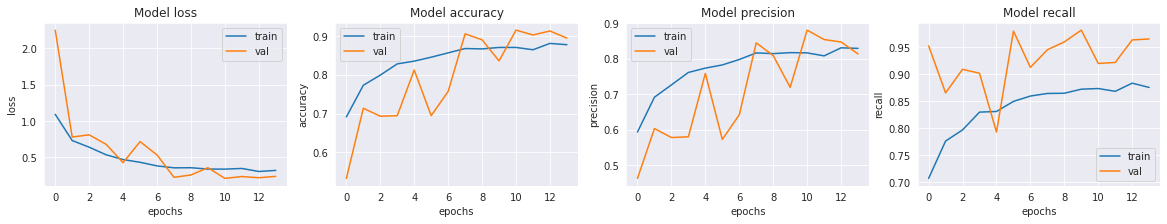

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['loss', 'accuracy', 'precision', 'recall']):
    ax[i].plot(history_effnetb4.history[met])
    ax[i].plot(history_effnetb4.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

###### Predict on test set

In [ ]:
loss, acc, prec, rec = effnetb4.evaluate(test_batched)
print("Loss of the model is - " , loss)
print("Accuracy of the model is - " , acc*100 , "%")
print("Precision of the model is - " , prec)
print("Recall of the model is - " , rec)

170/170 [==============================] - 22s 130ms/step - loss: 0.2103 - accuracy: 0.9196 - precision: 0.8840 - recall: 0.9212
Loss of the model is -  0.21030360460281372
Accuracy of the model is -  91.96165204048157 %
Precision of the model is -  0.8840070366859436
Recall of the model is -  0.9212453961372375


## DarkNet (Based on DarkCovidNet)

Tulin Ozturk, et al.
**Automated detection of COVID-19 cases using deep neural networks with X-ray images.**
(2020)
[Github](https://github.com/ieee8023/covid-chestxray-dataset)
[Google Scholar](https://scholar.google.com/scholar_lookup?title=Automated%20detection%20of%20COVID-19%20cases%20using%20deep%20neural%20networks%20with%20X-ray%20images&publication_year=2020&author=T.%20Ozturk)

### Model definition

DarkNet block definition

In [ ]:
def darknet_block(filters, kernel_size=3, strides=1):
    block = Sequential([
        ZeroPadding2D(padding=(1, 1)),
        Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding='valid', use_bias=False),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
    ])
    return block

def triple_conv(prev, filters):
    return Sequential([
        darknet_block(filters),
        darknet_block(prev, kernel_size=1),  
        darknet_block(filters)
    ])

def max_pool():
    return MaxPool2D(pool_size=(2, 2), strides=2, padding='valid')

In [ ]:
def darknet_builder():
    model = Sequential([
        Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
        darknet_block(8),
        max_pool(),
        darknet_block(16),
        max_pool(),
        triple_conv(16, 32),
        max_pool(),
        triple_conv(32, 64),
        max_pool(),
        triple_conv(64, 128),
        max_pool(),
        triple_conv(128, 256),
        darknet_block(128, kernel_size=1),
        darknet_block(256),
        darknet_block(3),
        Flatten(),
        Dense(units=1, activation='sigmoid')
    ], name='DarkNet')
    
    return model

In [ ]:
darknet = darknet_builder()

METRICS = [
    'accuracy',
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall')
]

darknet.compile(
    optimizer=Adam(lr=0.001), # default: 0.001
    loss='binary_crossentropy',
    metrics=METRICS
)

In [ ]:
darknet.summary()
darknet.layers[4].layers[1].summary()

Model: "DarkNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_4 (Sequential)    (None, 256, 256, 8)       248       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 128, 128, 8)       0         
_________________________________________________________________
sequential_5 (Sequential)    (None, 128, 128, 16)      1216      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 64, 64, 16)        0         
_________________________________________________________________
sequential_9 (Sequential)    (None, 66, 66, 32)        10048     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 33, 33, 32)        0         
_________________________________________________________________
sequential_13 (Sequential)   (None, 35, 35, 64)        3955

### Training

In [ ]:
history_darknet = darknet.fit(
    train_batched,
    steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_batched,
    validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
    class_weight=class_weight_dict,
    callbacks = [learning_rate_decay, early_stopping],
)

Epoch 1/20
791/791 [==============================] - 105s 129ms/step - loss: 0.6477 - accuracy: 0.6210 - precision: 0.5218 - recall: 0.7182 - val_loss: 0.5196 - val_accuracy: 0.7204 - val_precision: 0.6230 - val_recall: 0.7949
Epoch 2/20
791/791 [==============================] - 100s 126ms/step - loss: 0.5464 - accuracy: 0.7224 - precision: 0.6207 - recall: 0.7816 - val_loss: 0.5921 - val_accuracy: 0.7064 - val_precision: 0.6254 - val_recall: 0.6969
Epoch 3/20
791/791 [==============================] - 99s 126ms/step - loss: 0.5193 - accuracy: 0.7427 - precision: 0.6468 - recall: 0.7965 - val_loss: 1.7708 - val_accuracy: 0.5126 - val_precision: 0.4551 - val_recall: 0.9946
Epoch 4/20
791/791 [==============================] - 100s 127ms/step - loss: 0.4369 - accuracy: 0.7850 - precision: 0.7041 - recall: 0.8033 - val_loss: 0.3415 - val_accuracy: 0.8417 - val_precision: 0.8197 - val_recall: 0.7840
Epoch 5/20
791/791 [==============================] - 101s 128ms/step - loss: 0.4115 - ac

### Evaluation

###### Visualize performance

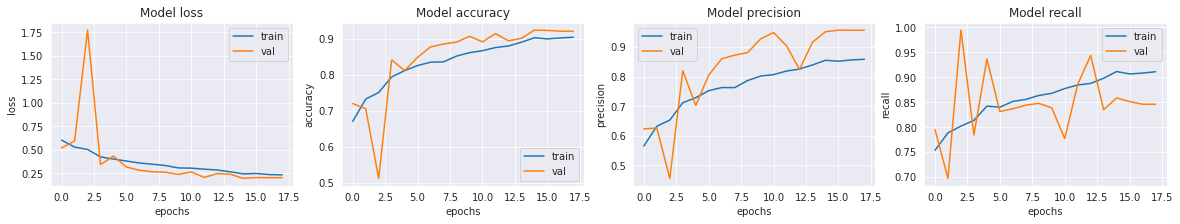

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['loss', 'accuracy', 'precision', 'recall']):
    ax[i].plot(history_darknet.history[met])
    ax[i].plot(history_darknet.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

###### Predict on test set

In [ ]:
loss, acc, prec, rec = darknet.evaluate(test_batched)
print("Loss of the model is - " , loss)
print("Accuracy of the model is - " , acc*100 , "%")
print("Precision of the model is - " , prec)
print("Recall of the model is - " , rec)

170/170 [==============================] - 4s 22ms/step - loss: 0.2070 - accuracy: 0.9196 - precision: 0.9581 - recall: 0.8370
Loss of the model is -  0.20699024200439453
Accuracy of the model is -  91.96165204048157 %
Precision of the model is -  0.9580712914466858
Recall of the model is -  0.83699631690979
